In [2]:

""" 
IMPORTS
"""
import os
import autograd.numpy as np
import pickle
import seaborn as sns
from collections import defaultdict
import pandas as pd

from one.api import ONE
from pprint import pprint
import numpy as np
import matplotlib.pyplot as plt
import brainbox.behavior.wheel as wh


functions_path =  '/home/ines/repositories/representation_learning_variability/Models/Sub-trial//3_postprocess_results/'
# functions_path = '/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability//Models/Sub-trial//3_postprocess_results/'
os.chdir(functions_path)
from postprocessing_functions import remove_states_str, best__kappa, best_lag_kappa, state_identifiability
from plotting_functions import plot_x_y_dynamics, plot_avg_state, align_bin_design_matrix, states_per_trial_phase, plot_states_aligned_trial, plot_states_aligned, traces_over_few_sates
functions_path =  '/home/ines/repositories/representation_learning_variability/Functions/'
# functions_path = '/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability/Functions/'
os.chdir(functions_path)
from one_functions_generic import prepro
from design_functions import wheel_velocity
# one = ONE(base_url='https://alyx.internationalbrainlab.org')
one = ONE(mode='remote')

In [3]:
bin_size = 0.1
multiplier = 1/bin_size

event_type_list = ['goCueTrigger_times']  # , 'feedback_times', 'firstMovement_times'
event_type_name = ['Go cue']  # , 'Feedback time', 'First movement onset'

num_train_batches = 5
threshold = 0.05
sticky = False

# Values for grid search (should get this from results)
last_lag = 20
lag_step = 2
start_lag = 1
Lags = list(range(start_lag, last_lag, lag_step))
kappas = [0, 1, 5, 10, 100, 500, 1000, 2000, 5000, 7000, 10000]

In [5]:
# Load preprocessed data
prepro_results_path = '/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability/Models/Sub-trial/4_analyses/'
prepro_results_path = '/home/ines/repositories/representation_learning_variability/Models/Sub-trial/4_analyses/'

os.chdir(prepro_results_path)
states_trial_type = pickle.load(open(prepro_results_path + "states_trial_type_10oct2024.pkl", "rb"))

# Load preprocessed data
prepro_results_path = '/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability/DATA/Sub-trial/Design matrix/v4_5Jul2024/0.1/'
prepro_results_path = '/home/ines/repositories/representation_learning_variability/DATA/Sub-trial/Design matrix/v4_5Jul2024/0.1/'

os.chdir(prepro_results_path)
design_matrix = pickle.load(open(prepro_results_path + "design_matrix_46794e05-3f6a-4d35-afb3-9165091a5a74_CSHL045_0.1", "rb"))

In [6]:
mouse_name = 'CSHL045'
session = '46794e05-3f6a-4d35-afb3-9165091a5a74'

states = states_trial_type.loc[states_trial_type['session']==session]

session_trials = one.load_object(session, obj='trials', namespace='ibl')
session_trials = session_trials.to_df()

# Wheel
wheel = one.load_object(session, 'wheel', collection='alf')
pos, wheel_times = wh.interpolate_position(wheel.timestamps, wheel.position)

inverted_mapping = {unique: key for unique, key in zip(states['most_likely_states'].unique(), states['identifiable_states'].unique())}
columns_to_standardize = ['avg_wheel_vel', 'Lick count', 'whisker_me']

init = 0
inter = 5 
end = init + inter


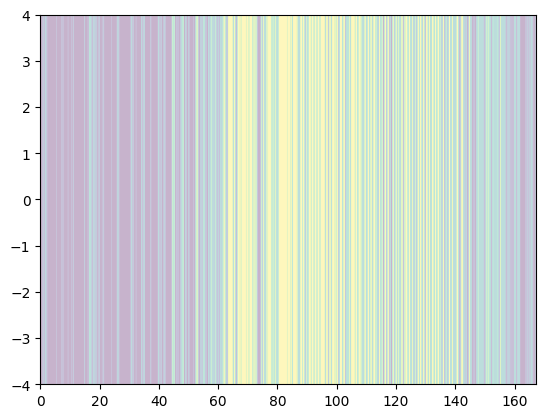

In [90]:
plt.imshow(np.concatenate([states['most_likely_states']])[None,:], 
        extent=(0, len(np.concatenate([states['most_likely_states']]))/10, plot_min, plot_max),
        aspect="auto",
        cmap='viridis',
        alpha=0.3)



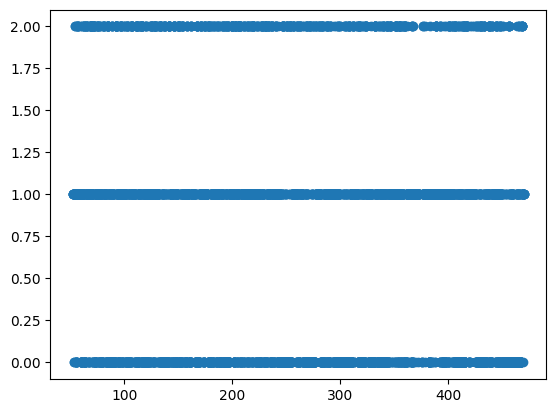

In [15]:
plt.scatter((states['Bin']+0.5)/10, states['most_likely_states'])
# plt.xlim(init, 1000)


(-4.0, 4.0)

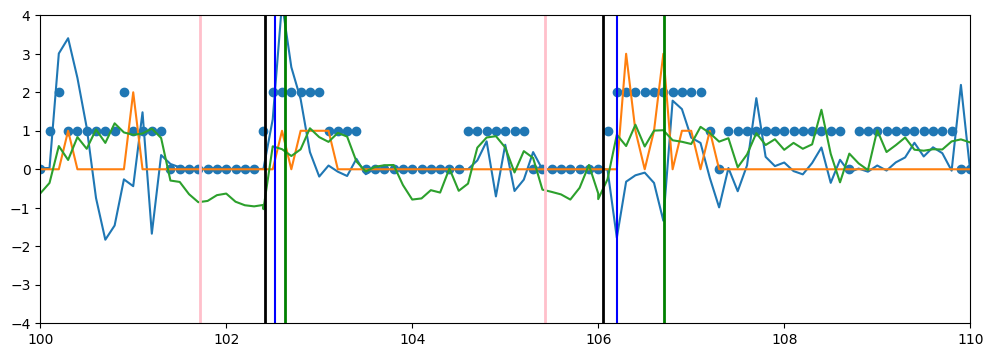

In [22]:

plt.figure(figsize=[12, 4])
init = 100
end = init + 10
plot_min = -4
plot_max = 4
plt.plot((design_matrix['Bin']+0.5)/10, design_matrix['avg_wheel_vel'])
plt.plot((design_matrix['Bin']+0.5)/10, design_matrix['Lick count'])
plt.plot((design_matrix['Bin']+0.5)/10, design_matrix['whisker_me'])
plt.scatter((states['Bin']+0.5)/10, states['most_likely_states'])

plt.vlines(np.array(session_trials['goCueTrigger_times']), plot_min, plot_max, label='Stim On', 
            color='Black', linewidth=2)
plt.vlines(np.array(session_trials.loc[session_trials['feedbackType']==1, 'feedback_times']), 
            plot_min, plot_max, label='Correct', color='Green', linewidth=2)
plt.vlines(np.array(session_trials.loc[session_trials['feedbackType']==-1, 'feedback_times']), 
            plot_min, plot_max, label='Incorrect', color='Red', linewidth=2)
plt.vlines(np.array(session_trials['firstMovement_times']), plot_min, plot_max, label='First movement', color='Blue')
plt.vlines(np.array((session_trials['goCueTrigger_times'] - session_trials['quiescencePeriod'])), 
            plot_min, plot_max, label='Quiescence start', color='Pink', linewidth=2)


# a = design_matrix.merge(states[['Bin', 'most_likely_states']], on='Bin', how='outer').copy()
# plt.imshow(np.concatenate([a['most_likely_states']])[None,:], 
#         extent=(init, end, plot_min, plot_max),
#         aspect="auto",
#         cmap='viridis',
#         alpha=0.3)

plt.xlim(init, end)
plt.ylim([plot_min, plot_max])


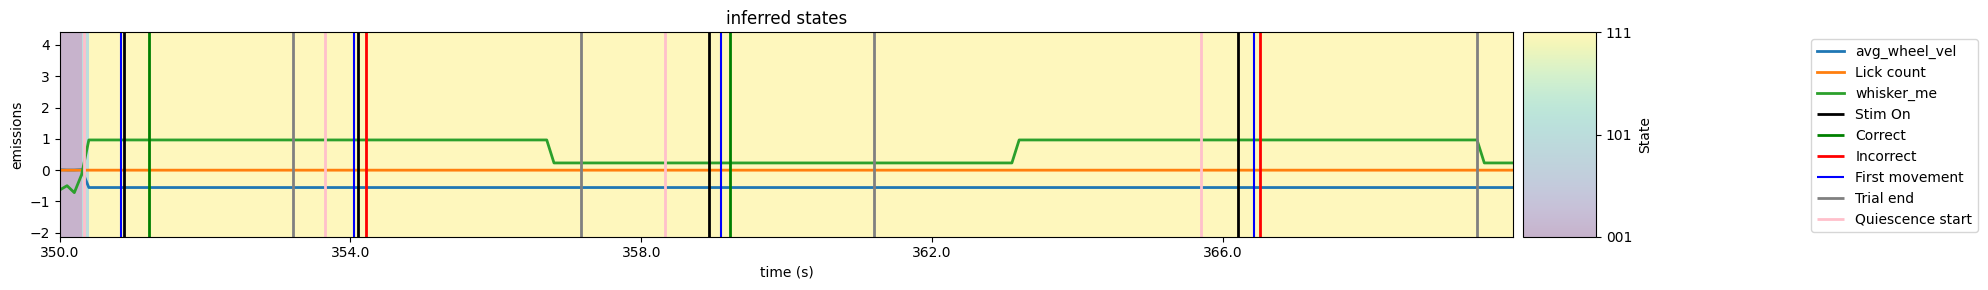

In [64]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
# design_matrix
inverted_mapping = {unique: key for unique, key in zip(states['most_likely_states'].unique(), states['identifiable_states'].unique())}
columns_to_standardize = ['avg_wheel_vel', 'Lick count', 'whisker_me']

init = 3500
inter = 200
end = init + inter



fig, axs = plt.subplots(1, 1, sharex=True, sharey=True, figsize=(20, 3))

df_normalized = design_matrix.merge(states, on='Bin').copy()
use_normalized = df_normalized.loc[(df_normalized['Bin']>init) & (df_normalized['Bin']<end)]

# To make sure color code is used correctly
number_of_states = len(use_normalized['most_likely_states'].unique()) - np.sum(np.isnan(use_normalized['most_likely_states'].unique()))
states_to_append = np.arange(0, number_of_states, 1)

# Plot original values
if len(columns_to_standardize) == 3:
    use_index0 = ~np.isnan(use_normalized[columns_to_standardize[0]])
    use_time0 = np.arange(0, len(use_index0), 1)  # NOTE! If there are NaNs, x axis label will have the time wrong # NOTE!!
    use_index1 = ~np.isnan(use_normalized[columns_to_standardize[1]])
    use_time1 = np.arange(0, len(use_index1), 1)  # NOTE! If there are NaNs, x axis label will have the time wrong # NOTE!!
    use_index2 = ~np.isnan(use_normalized[columns_to_standardize[2]])
    use_time2 = np.arange(0, len(use_index2), 1)  # NOTE! If there are NaNs, x axis label will have the time wrong # NOTE!!

    axs.plot(use_time0, use_normalized[columns_to_standardize[0]], label=columns_to_standardize[0], linewidth=2)
    axs.plot(use_time1, use_normalized[columns_to_standardize[1]], label=columns_to_standardize[1], linewidth=2)
    axs.plot(use_time2, use_normalized[columns_to_standardize[2]], label=columns_to_standardize[2], linewidth=2)
    
    # axs.plot(use_normalized['Bin']-init, use_normalized[columns_to_standardize[0]], label=columns_to_standardize[0], linewidth=2)
    # axs.plot(use_normalized['Bin']-init, use_normalized[columns_to_standardize[1]], label=columns_to_standardize[1], linewidth=2)
    # axs.plot(use_normalized['Bin']-init, use_normalized[columns_to_standardize[2]], label=columns_to_standardize[2], linewidth=2)
    plot_max = np.max([use_normalized[columns_to_standardize[0]], 
                        use_normalized[columns_to_standardize[1]],
                        use_normalized[columns_to_standardize[2]]])
    plot_min = np.min([use_normalized[columns_to_standardize[0]], 
                        use_normalized[columns_to_standardize[1]],
                        use_normalized[columns_to_standardize[2]]])

cax = axs.imshow(np.concatenate([use_normalized['most_likely_states'], states_to_append])[None,:], 
        extent=(0, len(np.concatenate([use_normalized['most_likely_states'], states_to_append])), plot_min, plot_max),
        aspect="auto",
        cmap='viridis',
        alpha=0.3) 

divider = make_axes_locatable(axs)
cax_colorbar = divider.append_axes("right", size="5%", pad=0.1)
cbar = fig.colorbar(cax, cax=cax_colorbar, ax=axs)

cbar.set_label('State')
if len(inverted_mapping) > 0:
    # Set the ticks and labels based on the dictionary
    cbar.set_ticks(list(inverted_mapping.keys()))
    cbar.set_ticklabels(list(inverted_mapping.values()))

axs.hlines(0, init, end, color='Black', linestyles='dashed', linewidth=2)
axs.vlines(np.array(session_trials['goCueTrigger_times'] * 1*multiplier)-init, plot_min, plot_max, label='Stim On', 
            color='Black', linewidth=2)
axs.vlines(np.array(session_trials.loc[session_trials['feedbackType']==1, 'feedback_times'] * 1*multiplier)-init, 
            plot_min, plot_max, label='Correct', color='Green', linewidth=2)
axs.vlines(np.array(session_trials.loc[session_trials['feedbackType']==-1, 'feedback_times'] * 1*multiplier)-init, 
            plot_min, plot_max, label='Incorrect', color='Red', linewidth=2)
axs.vlines(np.array(session_trials['firstMovement_times'] * 1*multiplier)-init, plot_min, plot_max, label='First movement', color='Blue')
axs.vlines(np.array(session_trials['intervals_0'] * 1*multiplier)-init, plot_min, plot_max, label='Trial end', color='Grey', linewidth=2)
axs.vlines(np.array((session_trials['goCueTrigger_times'] - session_trials['quiescencePeriod']) * 1*multiplier)-init, 
            plot_min, plot_max, label='Quiescence start', color='Pink', linewidth=2)

axs.set_ylim(plot_min, plot_max)
axs.set_ylabel("emissions")
axs.set_xlabel("time (s)")
axs.set_xlim(0, end-init)
axs.set_xticks(np.arange(0, inter, inter/5),np.arange(init/multiplier, 
                                                        end/multiplier, (inter/multiplier)/5))
axs.set_title("inferred states")
axs.legend(loc='upper left', bbox_to_anchor=(1.2, 1))

plt.tight_layout()
plt.show()

In [61]:
use_normalized

,Bin,avg_wheel_vel,Lick count,wheel_final,whisker_me,left_X,left_Y,right_X,right_Y,nose_X,...,response,elongation,wsls,most_likely_states,trial_id,label,mouse_name,session,identifiable_states,broader_label
5277,1501.0,-0.890142,0.0,0.586817,0.616526,750.021108,640.117175,657.302558,389.406605,281.286343,...,0.303584,1.333064,wst,2.0,22.0,Correct feedback,CSHL045,46794e05-3f6a-4d35-afb3-9165091a5a74,111,ITI
5278,1502.0,0.911818,1.0,0.566533,0.657645,741.185455,650.763906,659.811910,411.756357,281.771749,...,0.303584,1.333064,wst,2.0,22.0,Correct feedback,CSHL045,46794e05-3f6a-4d35-afb3-9165091a5a74,111,ITI
5279,1503.0,0.066263,0.0,0.641733,0.840491,750.851784,680.981522,647.424100,440.643031,281.274151,...,0.303584,1.333064,wst,2.0,22.0,Correct feedback,CSHL045,46794e05-3f6a-4d35-afb3-9165091a5a74,111,ITI
5280,1504.0,0.085452,2.0,0.645287,0.306579,746.807836,690.071424,645.086212,444.619484,279.562812,...,0.303584,1.333064,wst,2.0,22.0,Correct feedback,CSHL045,46794e05-3f6a-4d35-afb3-9165091a5a74,111,ITI
5281,1505.0,0.208753,0.0,0.665490,0.453486,752.876472,694.869308,642.572988,448.789781,278.406567,...,0.303584,1.333064,wst,2.0,22.0,Correct feedback,CSHL045,46794e05-3f6a-4d35-afb3-9165091a5a74,111,ITI
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6123,1695.0,0.010512,0.0,0.000879,-0.122780,784.502602,683.423589,642.234879,447.779096,274.078330,...,1.128682,0.063435,wsh,0.0,26.0,Stimulus left,CSHL045,46794e05-3f6a-4d35-afb3-9165091a5a74,001,Stimulus
6124,1696.0,0.017505,0.0,0.002144,-0.095936,784.329923,683.768094,642.199084,447.911180,276.352708,...,1.128682,0.063435,wsh,1.0,26.0,Stimulus left,CSHL045,46794e05-3f6a-4d35-afb3-9165091a5a74,101,Stimulus
6125,1697.0,0.256166,0.0,0.011595,0.336771,791.954358,691.477661,660.989380,453.974082,277.456622,...,1.128682,0.063435,wsh,2.0,26.0,Stimulus left,CSHL045,46794e05-3f6a-4d35-afb3-9165091a5a74,111,Stimulus
6126,1698.0,1.703997,2.0,0.110770,1.033567,815.749232,722.065798,677.189433,488.546740,281.732558,...,1.128682,0.063435,wsh,1.0,26.0,Right choice,CSHL045,46794e05-3f6a-4d35-afb3-9165091a5a74,101,Choice


In [ ]:
        
""" Plot raw traces over states """
init = int(np.min(empirical_data['Bin'])/10+10) * multiplier # First bin
init = 250*multiplier
inter = 10 * multiplier
inter = 20 * multiplier
traces_over_few_sates(init, inter, empirical_data, session_trials, var_names, multiplier, inverted_mapping)

In [ ]:
plt.plot(wheel_vel['Wheel times'], wheel_vel['Wheel position'])
plt.xlim(2, 6)
plt.ylim([-5, 5])
vel = np.diff(wheel_vel['Wheel position'])/np.diff(wheel_vel['Wheel times'])
plt.plot(wheel_vel['Wheel times'][1:],vel)
plt.xlim(2, 6)
plt.ylim([-5, 5])
plt.plot((wheel_vel['Bin']+0.5)/10, wheel_vel['avg_wheel_vel'])
plt.xlim(2, 6)
plt.ylim([-5, 5])

In [ ]:
plt.plot(wheel_vel['Wheel times'], wheel_vel['Wheel position'])
plt.xlim(2, 6)
plt.ylim([-5, 5])
vel = np.diff(wheel_vel['Wheel position'])/np.diff(wheel_vel['Wheel times'])
plt.plot(wheel_vel['Wheel times'][1:],vel)
plt.xlim(2, 6)
plt.ylim([-5, 5])
plt.plot((wheel_vel['Bin']+0.5)/10, wheel_vel['avg_wheel_vel'])
plt.xlim(2, 6)
plt.ylim([-5, 5])